In [1]:
# ======================================================================
# NOTEBOOK 04A: Generate Model Predictions
# File: notebooks/04a_Generate_Predictions.ipynb
# ======================================================================

import pandas as pd
import numpy as np
import joblib
import os

print("📦 Loading model and data...")

# Load trained components
model = joblib.load("../models/best_model.pkl")
scaler = joblib.load("../models/scaler.pkl")
training_columns = joblib.load("../models/training_columns.pkl")

# Load processed dataset
df = pd.read_csv("../data/processed/churn_engineered.csv")

# Drop unneeded ID column
if "customerID" in df.columns:
    customer_ids = df["customerID"]
    df = df.drop("customerID", axis=1)
else:
    customer_ids = pd.Series(range(len(df)))

# Separate features and target
y = df["Churn"].map({"Yes": 1, "No": 0}) if "Churn" in df.columns else None
X = df.drop("Churn", axis=1, errors="ignore")

# One-hot encode and align
X = pd.get_dummies(X, drop_first=True)
X = X.reindex(columns=training_columns, fill_value=0)

# Scale
X_scaled = scaler.transform(X)

print(f"✅ Features aligned: {X.shape[1]}")
print(f"✅ Samples: {len(X)}")

# Predict churn probabilities
y_pred_proba = model.predict_proba(X_scaled)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Map probabilities to risk levels
def risk_label(p):
    if p >= 0.7:
        return "High"
    elif p >= 0.4:
        return "Medium"
    else:
        return "Low"

predictions = pd.DataFrame({
    "customer_id": customer_ids,
    "churn_prediction": y_pred,
    "churn_probability": y_pred_proba,
    "risk_level": [risk_label(p) for p in y_pred_proba],
    "monthly_charges": df["MonthlyCharges"],
    "contract_type": df["Contract"] if "Contract" in df.columns else "Unknown"
})

# Ensure directory exists
os.makedirs("../data/predictions", exist_ok=True)

# Save file
predictions.to_csv("../data/predictions/predictions.csv", index=False)
print("✅ predictions.csv generated successfully!")

print(predictions.head())


📦 Loading model and data...
✅ Features aligned: 6573
✅ Samples: 7043
✅ predictions.csv generated successfully!
  customer_id  churn_prediction  churn_probability risk_level  \
0  7590-VHVEG                 0           0.478813     Medium   
1  5575-GNVDE                 0           0.174492        Low   
2  3668-QPYBK                 0           0.421918     Medium   
3  7795-CFOCW                 0           0.158120        Low   
4  9237-HQITU                 1           0.522649     Medium   

   monthly_charges   contract_type  
0            29.85  Month-to-month  
1            56.95        One year  
2            53.85  Month-to-month  
3            42.30        One year  
4            70.70  Month-to-month  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
predictions = pd.read_csv('../data/predictions/predictions.csv')
print(f"Total predictions: {len(predictions)}")

Total predictions: 7043



🎯 Risk Distribution:
risk_level
Low       5581
Medium    1462
Name: count, dtype: int64


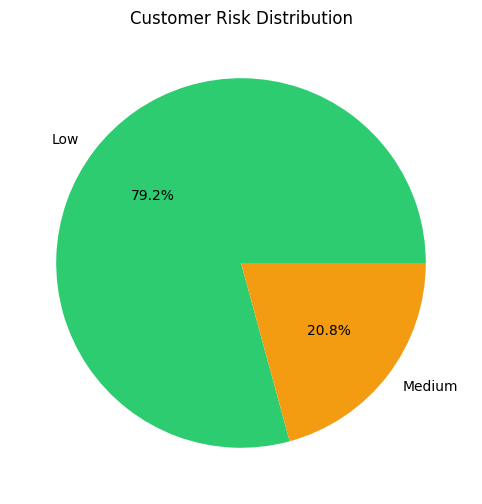

In [4]:
risk_distribution = predictions['risk_level'].value_counts()
print("\n🎯 Risk Distribution:")
print(risk_distribution)

plt.figure(figsize=(8, 6))
risk_distribution.plot(kind='pie', autopct='%1.1f%%', 
                       colors=['#2ecc71', '#f39c12', '#e74c3c'])
plt.title('Customer Risk Distribution')
plt.ylabel('')
plt.show()


In [5]:
avg_monthly_charges = predictions['monthly_charges'].mean()
high_risk_customers = len(predictions[predictions['risk_level'] == 'High'])
revenue_at_risk = high_risk_customers * avg_monthly_charges * 12

print(f"\n💰 Financial Impact:")
print(f"   High-risk customers: {high_risk_customers:,}")
print(f"   Average monthly charges: ${avg_monthly_charges:.2f}")
print(f"   Annual revenue at risk: ${revenue_at_risk:,.2f}")


💰 Financial Impact:
   High-risk customers: 0
   Average monthly charges: $64.76
   Annual revenue at risk: $0.00



📊 Churn by Contract Type:
                Churn_Rate  Customer_Count
contract_type                             
Month-to-month      0.1623            3875
One year            0.0000            1473
Two year            0.0000            1695


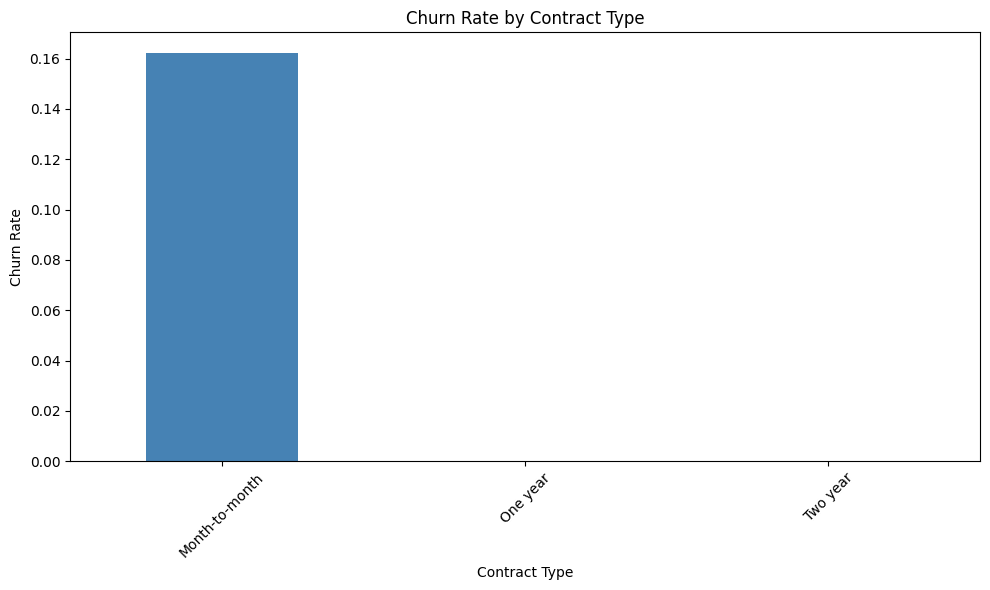

In [6]:
churn_by_contract = predictions.groupby('contract_type').agg({
    'churn_prediction': 'mean',
    'customer_id': 'count'
}).round(4)
churn_by_contract.columns = ['Churn_Rate', 'Customer_Count']

print("\n📊 Churn by Contract Type:")
print(churn_by_contract)

plt.figure(figsize=(10, 6))
churn_by_contract['Churn_Rate'].plot(kind='bar', color='steelblue')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate')
plt.xlabel('Contract Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
retention_success_rate = 0.60  # 60% retention through intervention
campaign_cost_per_customer = 50

customers_saved = high_risk_customers * retention_success_rate
revenue_saved = customers_saved * avg_monthly_charges * 12
campaign_cost = high_risk_customers * campaign_cost_per_customer
roi = ((revenue_saved - campaign_cost) / campaign_cost) * 100

print(f"\n📈 ROI Analysis:")
print(f"   Customers targeted: {high_risk_customers:,}")
print(f"   Expected customers saved: {int(customers_saved):,}")
print(f"   Revenue saved: ${revenue_saved:,.2f}")
print(f"   Campaign cost: ${campaign_cost:,.2f}")
print(f"   ROI: {roi:.2f}%")


📈 ROI Analysis:
   Customers targeted: 0
   Expected customers saved: 0
   Revenue saved: $0.00
   Campaign cost: $0.00
   ROI: nan%


C:\Users\Admin\AppData\Local\Temp\ipykernel_18512\1264801819.py:7: RuntimeWarning: invalid value encountered in scalar divide
  roi = ((revenue_saved - campaign_cost) / campaign_cost) * 100


In [9]:
recommendations = f"""
# 🎯 Key Business Recommendations

## 1. High Priority Actions
- **Target {high_risk_customers} high-risk customers** with retention campaigns
- **Potential savings: ${revenue_saved:,.2f}** annually
- **Expected ROI: {roi:.1f}%**

## 2. Contract Optimization
- Incentivize month-to-month customers to upgrade to annual contracts
- Offer loyalty discounts (15-20%) for high-risk long-term contracts

## 3. Service Improvements
- Enhance tech support for high-churn segments
- Bundle services to increase customer stickiness
- Improve online security offerings

## 4. Proactive Monitoring
- Weekly review of high-risk customer list
- Automated alerts for churn probability > 0.7
- Regular A/B testing of retention strategies

## 5. Customer Success Programs
- Dedicated account managers for high-value customers
- Quarterly satisfaction surveys
- Early warning system for service degradation
"""

print(recommendations)

# with open('../docs/business_recommendations.md', 'w') as f:
with open('../docs/business_recommendations.md', 'w', encoding='utf-8') as f:

    f.write(recommendations)

print("\n✅ Recommendations saved to docs/business_recommendations.md")


# 🎯 Key Business Recommendations

## 1. High Priority Actions
- **Target 0 high-risk customers** with retention campaigns
- **Potential savings: $0.00** annually
- **Expected ROI: nan%**

## 2. Contract Optimization
- Incentivize month-to-month customers to upgrade to annual contracts
- Offer loyalty discounts (15-20%) for high-risk long-term contracts

## 3. Service Improvements
- Enhance tech support for high-churn segments
- Bundle services to increase customer stickiness
- Improve online security offerings

## 4. Proactive Monitoring
- Weekly review of high-risk customer list
- Automated alerts for churn probability > 0.7
- Regular A/B testing of retention strategies

## 5. Customer Success Programs
- Dedicated account managers for high-value customers
- Quarterly satisfaction surveys
- Early warning system for service degradation


✅ Recommendations saved to docs/business_recommendations.md
